In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import sklearn
import random
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from distcorr import distcorr

In [10]:
iris = load_iris()

In [11]:
# Filter the data and convert to numpy

dataset = iris['data']
dataset = np.asarray(dataset)

In [12]:
training_features = dataset[:, :-1]
target_features = dataset[:, -1]

In [13]:
# Create bins for stratified split

bins = np.linspace(0, 6)
y_binned = np.digitize(target_features, bins)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(training_features, target_features, random_state=0, stratify=y_binned)

In [15]:
x_train = torch.from_numpy(x_train)
x_train = x_train.view(1, x_train.shape[0], 3)

x_test = torch.from_numpy(x_test)
x_test = x_test.view(1, x_test.shape[0], 3)

y_train = torch.from_numpy(y_train)
y_train = y_train.view(1, y_train.shape[0], 1)

y_test = torch.from_numpy(y_test)
y_test = y_test.view(1, y_test.shape[0], 1)

In [17]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.enc1 = nn.Linear(in_features=3, out_features=2)
        self.enc2 = nn.Linear(in_features=2, out_features=1)
    
    def forward(self, x):
        x = F.leaky_relu(self.enc1(x))
        x = self.enc2(x)
        return x

In [18]:
# Create a seed for consistent output during experimentation

random.seed(1)
torch.manual_seed(random.randint(1, 10))
net = Autoencoder().double()

In [19]:
NUM_EPOCHS = 500
LEARNING_RATE = 0.01
BATCH_SIZE = 120

In [20]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [21]:
def train(net):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        for data, target in zip(x_train, y_train):
            optimizer.zero_grad()
            outputs = net(data.double())
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if epoch == NUM_EPOCHS-1:
                for i in range(len(data)):
                    print("Input: ", data[i])
                    print("Target: ", target[i])
                    print("Outputs: ", outputs[i])

        loss = running_loss / len(x_train)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'
            .format(epoch+1, NUM_EPOCHS, loss))
    return train_loss

def test(net):

    net.eval()

    with torch.no_grad():
        test_loss = []
        running_loss = 0.0
        for data, target in zip(x_test, y_test):
            outputs = net(data.double())
            loss = criterion(outputs, target)
            running_loss += loss.item()

            for i in range(len(data)):
                print("Input: ", data[i])
                print("Target: ", target[i])
                print("Outputs: ", outputs[i])
                
        loss = running_loss / len(x_test)
        test_loss.append(loss)
        print('Test Loss: {:.3f}'.format(loss))

        return test_loss
        

In [22]:
train_loss1 = train(net)


990], dtype=torch.float64, grad_fn=<SelectBackward>)
Input:  tensor([6.3000, 3.4000, 5.6000], dtype=torch.float64)
Target:  tensor([2.4000], dtype=torch.float64)
Outputs:  tensor([2.0191], dtype=torch.float64, grad_fn=<SelectBackward>)
Input:  tensor([6.4000, 3.2000, 4.5000], dtype=torch.float64)
Target:  tensor([1.5000], dtype=torch.float64)
Outputs:  tensor([1.5214], dtype=torch.float64, grad_fn=<SelectBackward>)
Input:  tensor([6.1000, 2.6000, 5.6000], dtype=torch.float64)
Target:  tensor([1.4000], dtype=torch.float64)
Outputs:  tensor([1.9659], dtype=torch.float64, grad_fn=<SelectBackward>)
Input:  tensor([6.9000, 3.1000, 5.1000], dtype=torch.float64)
Target:  tensor([2.3000], dtype=torch.float64)
Outputs:  tensor([1.7497], dtype=torch.float64, grad_fn=<SelectBackward>)
Input:  tensor([5.8000, 2.7000, 3.9000], dtype=torch.float64)
Target:  tensor([1.2000], dtype=torch.float64)
Outputs:  tensor([1.2553], dtype=torch.float64, grad_fn=<SelectBackward>)
Input:  tensor([6.4000, 2.8000, 

Text(0, 0.5, 'Loss')

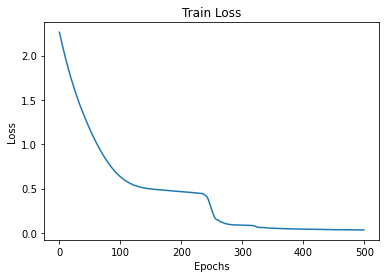

In [23]:
plt.figure()
plt.plot(train_loss1)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [24]:
test_result = test(net)

Input:  tensor([7.4000, 2.8000, 6.1000], dtype=torch.float64)
Target:  tensor([1.9000], dtype=torch.float64)
Outputs:  tensor([2.1106], dtype=torch.float64)
Input:  tensor([6.7000, 2.5000, 5.8000], dtype=torch.float64)
Target:  tensor([1.8000], dtype=torch.float64)
Outputs:  tensor([2.0208], dtype=torch.float64)
Input:  tensor([6.0000, 2.2000, 4.0000], dtype=torch.float64)
Target:  tensor([1.], dtype=torch.float64)
Outputs:  tensor([1.2443], dtype=torch.float64)
Input:  tensor([5.5000, 4.2000, 1.4000], dtype=torch.float64)
Target:  tensor([0.2000], dtype=torch.float64)
Outputs:  tensor([0.2325], dtype=torch.float64)
Input:  tensor([7.2000, 3.0000, 5.8000], dtype=torch.float64)
Target:  tensor([1.6000], dtype=torch.float64)
Outputs:  tensor([2.0424], dtype=torch.float64)
Input:  tensor([6.3000, 2.7000, 4.9000], dtype=torch.float64)
Target:  tensor([1.8000], dtype=torch.float64)
Outputs:  tensor([1.6779], dtype=torch.float64)
Input:  tensor([5.5000, 2.5000, 4.0000], dtype=torch.float64)


In [25]:
torch.save(net, './model1')

In [29]:
extracted_data = iris['data']

In [30]:
features = extracted_data[:, :-1]

input_features = torch.from_numpy(features)
input_features.view(1, 150, 3)

tensor([[[5.1000, 3.5000, 1.4000],
         [4.9000, 3.0000, 1.4000],
         [4.7000, 3.2000, 1.3000],
         [4.6000, 3.1000, 1.5000],
         [5.0000, 3.6000, 1.4000],
         [5.4000, 3.9000, 1.7000],
         [4.6000, 3.4000, 1.4000],
         [5.0000, 3.4000, 1.5000],
         [4.4000, 2.9000, 1.4000],
         [4.9000, 3.1000, 1.5000],
         [5.4000, 3.7000, 1.5000],
         [4.8000, 3.4000, 1.6000],
         [4.8000, 3.0000, 1.4000],
         [4.3000, 3.0000, 1.1000],
         [5.8000, 4.0000, 1.2000],
         [5.7000, 4.4000, 1.5000],
         [5.4000, 3.9000, 1.3000],
         [5.1000, 3.5000, 1.4000],
         [5.7000, 3.8000, 1.7000],
         [5.1000, 3.8000, 1.5000],
         [5.4000, 3.4000, 1.7000],
         [5.1000, 3.7000, 1.5000],
         [4.6000, 3.6000, 1.0000],
         [5.1000, 3.3000, 1.7000],
         [4.8000, 3.4000, 1.9000],
         [5.0000, 3.0000, 1.6000],
         [5.0000, 3.4000, 1.6000],
         [5.2000, 3.5000, 1.5000],
         [5.2000, 3.

In [31]:
load_model = torch.load('model1')
new_column = load_model(input_features.double())

In [33]:
comparison_column = extracted_data[:, 2]

In [34]:
print(distcorr(comparison_column, extracted_data[:, 3]))
print(scipy.stats.pearsonr(comparison_column, extracted_data[:, 3]))

0.9736309347509411
(0.962865431402796, 4.6750039073285846e-86)


In [35]:
predicted_column = new_column.detach().numpy().flatten()

In [36]:
predicted_column.shape

(150,)

In [37]:
print(distcorr(comparison_column, predicted_column))
print(scipy.stats.pearsonr(comparison_column, predicted_column))

0.9989279640938875
(0.9973703092129773, 1.3307185400335482e-170)


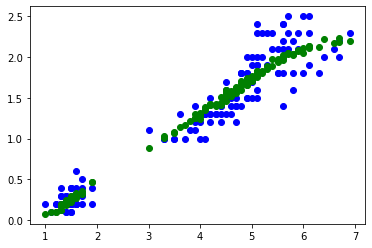

In [44]:
plt.scatter(comparison_column, target_features, color='blue')
plt.scatter(comparison_column, predicted_column, color='green')
plt.show()

In [47]:
from scipy import stats
from statsmodels.stats import weightstats as stets

ttest, pval = stats.ttest_ind(target_features, predicted_column)
print("P-value for significance: ", pval)
print("TTEST: ", ttest)

if pval<0.05:
    print("Conclusion: Reject Null Hypothesis")
else:
    print("Conclusion: Accept Null Hypothesis")

P-value for significance:  0.989770749162647
TTEST:  -0.012831577895934526
Conclusion: Accept Null Hypothesis


In [48]:
# new_dataset = np.concatenate((features, new_column.detach().numpy()), axis=1)
# np.set_printoptions(precision=2, suppress=True)
# new_dataset
# np.savetxt('first_iris.csv', new_dataset)